In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist

import nltk
import string
# Remove # when execute code initial time in an AWS SageMaker session
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from src import nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Wall Street Forum Topic Modeling

## Data Import and Tf-Idf Vectorization

In [2]:
wallstreet = pd.read_csv('data/wallstreet_master.csv', engine='python')
wallstreet['lemmatized_tokens'] = wallstreet['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))
docs_raw = [' '.join(d) for d in wallstreet['lemmatized_tokens']]

In [3]:
n_topics = 20
max_doc_freq = 0.7
min_doc_freq = 4
max_features = 10000
ngram_rng = [1, 1]
max_iterations = 25
random_state=3
min_len = 1

In [4]:
docs_vectorized, vectorizer = nlp_topic_utils.tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_features, ngram_rng)

---
# Incremental PCA

In [11]:
def select_ipca_num_components(var_ratio, var_explained_threshold):
    '''
    Determines the number of components required for TruncatedSVD to achieve the threshold of variance explained.
    '''
    total_var = 0
    n_components = 0
    
    for explained_var in var_ratio:
        total_var += explained_var
        n_components += 1
        
        if total_var >= var_explained_threshold:
            break
    
    return n_components

In [16]:
n_components = int(docs_vectorized.shape[1] / 2)
ipca = IncrementalPCA(n_components=n_components).fit(docs_vectorized)

In [17]:
ipca_var_explained = pd.DataFrame()
ipca_var_explained['num_components'] = np.arange(n_components)
ipca_var_explained['cumulative_explained_variance'] = np.cumsum(ipca.explained_variance_ratio_)

fig = px.line(ipca_var_explained, x='num_components', y='cumulative_explained_variance', title='Incremental PCA Explained Variance Ratio by Number of Components',
             labels=dict(num_components='# of Components', cumulative_explained_variance='Explained Variance Ratio'))
fig.update_layout(width=1000, height=500)
fig.show();

In [24]:
#var_ratio = ipca.explained_variance_ratio_
#threshold= 0.9

# n_components = select_ipca_num_components(var_ratio, threshold)
ipca = IncrementalPCA(n_components=2980, batch_size=2980)#, batch)
ipca.fit(docs_vectorized)
docs_transformed = ipca.transform(docs_vectorized)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/decomposition/_incremental_pca.py:309: RuntimeWarning:

Mean of empty slice.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



MemoryError: Unable to allocate 1.06 GiB for an array with shape (142175811,) and data type float64

In [25]:
ipca = IncrementalPCA(n_components=2980, batch_size=2980)#, batch)
docs_transformed = ipca.fit_transform(docs_vectorized)

MemoryError: Unable to allocate 271. MiB for an array with shape (5961, 5961) and data type float64

---
## K-Means

In [5]:
vocab = list(vectorizer.vocabulary_.keys())


In [6]:
# Identify number of cluseters using the "Elbow" method

# distortion is the average of the squared distances from the cluster centers of the respective clusters.
distortions = []
distortion_map = {}

# Inertia is the sum of squared distances of samples to their closest cluster center
inertias = []
inertia_map = {}

k_rng = np.arange(5, 101, 5)

for k in k_rng:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(docs_vectorized)
    pred = kmeans.predict(docs_vectorized)
    centroids = kmeans.cluster_centers_
    
    d = sum(np.min(cdist(docs_vectorized.toarray(), centroids, metric='euclidean'), axis=1)) / docs_vectorized.shape[0]
    distortions.append(d)
    distortion_map[k] = d
    
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_

In [7]:
kmeans_desc = pd.DataFrame()
kmeans_desc['num_components'] = k_rng
kmeans_desc['distortion'] = distortions
kmeans_desc['inertia'] = inertias

kmeans_desc.to_csv('data/kmeans_desc.csv')

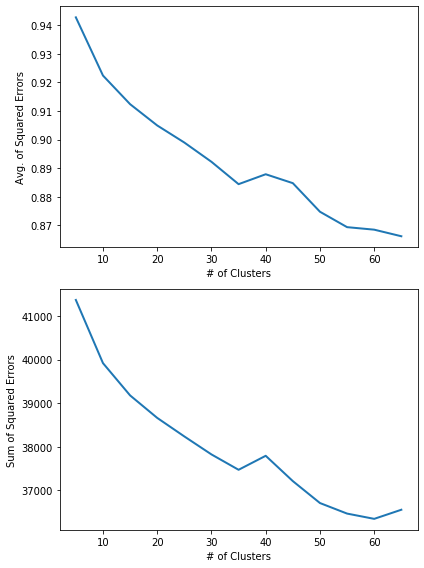

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))#, subplot_titles=('Distortion', 'Inertia'))

ax[0].plot(k_rng, distortions, linewidth=2)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Avg. of Squared Errors')

ax[1].plot(k_rng, inertias, linewidth=2)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Sum of Squared Errors')
plt.tight_layout(); 

In [29]:
def plot_elbow_graphs(k_rng, distortions, inertias):
    '''
    Use plots to determine optimal number of clusters.
    '''
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Distortion', 'Inertia'))

    fig.add_trace(go.Scatter(x=k_rng, y=distortions), row=1, col=1)
    fig.update_xaxes(title_text="# of Clusters", row=1, col=1)
    fig.update_yaxes(title_text="Average of Squared Errors", row=1, col=1)

    fig.add_trace(go.Scatter(x=k_rng, y=inertias), row=1, col=2)
    fig.update_xaxes(title_text="# of Clusters", row=1, col=2)
    fig.update_yaxes(title_text="Sum of Squared Errors", row=1, col=2)

    fig.update_layout(showlegend=False)

    fig.show();

In [31]:
plot_elbow_graphs(k_rng, distortions, inertias)

In [18]:
# Instiate KMeans model object.
# Input k
best_k = 60
kmeans = KMeans(n_clusters=best_k, random_state=random_state, n_jobs=-1)
kmeans.fit(docs_vectorized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=3, tol=0.0001, verbose=0)

In [19]:
print(k_clusters_centers.shape)

NameError: name 'k_clusters_centers' is not defined

In [20]:
clusters = kmeans.labels_
k_clusters_centers = kmeans.cluster_centers_
# original_space_centroids = tsvd.inverse_transform(k_clusters_centers)
# argsort() returns the indices of the sorted values.
ordered_centroids = k_clusters_centers.argsort()[:, ::-1]

In [23]:
n_top_words = 10
words = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(k_clusters_centers):
    top_words_arr = [words[i] for i in ordered_centroids[topic_idx, : n_top_words]]
    print("\nCluster #{}:".format(topic_idx+1))
    print(" ".join(top_words_arr))


Cluster #1:
wrote need know thanks good like market looking one work

Cluster #2:
guide cashout bank record ssn pack extra offer link retirement

Cluster #3:
bump store wsm market profile sold cc sale bonus check

Cluster #4:
profile weed kallashnikov carfentanyl ephedrine heroin ecstasy hcl amphetamine ketamine

Cluster #5:
eskimo testicle smashed nun sand arab ice consider drug vendor

Cluster #6:
bank account drop paypal transfer need wrote credit fund money

Cluster #7:
room chat everythingcc log change day fraud cashout bank one

Cluster #8:
vendor order market product quality wsm good wrote time new

Cluster #9:
shoutouts overdue supermod hero thief honor deserve dabbingtimes among boneskoopa

Cluster #10:
external allowed contact rule link read phished help offsite wsm

Cluster #11:
card italian cc credit sim service gift rdps selling debit

Cluster #12:
phished help rule wsm welcome broder moved vendor bro wrote

Cluster #13:
pm market icepapi name send wrote message sent wsm 

In [26]:
n_top_words = 10

def top_terms_by_cluster(model, vectorizer, n_top_words):
    '''
    Displays the most frequent selected number of words per cluster.
    
    '''
    
    clusters = kmeans.labels_
    
    k_clusters_centers = kmeans.cluster_centers_
    # original_space_centroids = tsvd.inverse_transform(k_clusters_centers)
    # argsort() returns the indices of the sorted values.
    ordered_centroids = k_clusters_centers.argsort()[:, ::-1]
    
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(k_clusters_centers):
        top_words_arr = [words[i] for i in ordered_centroids[topic_idx, : n_top_words]]
        print("\nCluster #{}:".format(topic_idx+1))
        print(" ".join(top_words_arr))

In [27]:
top_terms_by_cluster(kmeans, vectorizer, n_top_words)


Cluster #1:
wrote need know thanks good like market looking one work

Cluster #2:
guide cashout bank record ssn pack extra offer link retirement

Cluster #3:
bump store wsm market profile sold cc sale bonus check

Cluster #4:
profile weed kallashnikov carfentanyl ephedrine heroin ecstasy hcl amphetamine ketamine

Cluster #5:
eskimo testicle smashed nun sand arab ice consider drug vendor

Cluster #6:
bank account drop paypal transfer need wrote credit fund money

Cluster #7:
room chat everythingcc log change day fraud cashout bank one

Cluster #8:
vendor order market product quality wsm good wrote time new

Cluster #9:
shoutouts overdue supermod hero thief honor deserve dabbingtimes among boneskoopa

Cluster #10:
external allowed contact rule link read phished help offsite wsm

Cluster #11:
card italian cc credit sim service gift rdps selling debit

Cluster #12:
phished help rule wsm welcome broder moved vendor bro wrote

Cluster #13:
pm market icepapi name send wrote message sent wsm 